lab work №1.1

Student name - Khrystyna

Student surname - Zyryanova

Group - CS-32

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Ваш студентський номер
STUDENT_NO = 11

X_nonlin, y_nonlin = generate_regression_data(
    n_samples=300, 
    n_features=1, 
    mode='nonlinear', 
    noise=5.0, 
    n_outliers=10, 
    random_seed=STUDENT_NO, 
    return_coef=False)

# Встановлення стилю графіків
plt.style.use('seaborn-v0_8-whitegrid')

# Допоміжні функції

def generate_regression_data(
    n_samples=50, 
    n_features=1, 
    mode='linear', 
    noise=2.0, 
    n_outliers=5, 
    random_seed=42, 
    return_coef=False):
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features) * 10 - 5
    true_intercept = 0
    true_weights = np.zeros(n_features)
    
    if mode == 'linear':
        true_intercept = np.random.uniform(-3, 3)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = np.dot(X, true_weights) + true_intercept
    elif mode == 'nonlinear':
        if n_features < 1:
            raise ValueError("Nonlinear mode requires at least 1 feature.")
        
        true_intercept = np.random.uniform(-15, 15)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        
        # Використання функції f(x) = A*sin(B*x) + C
        A_true = true_weights[0] * 20
        B_true = 1.5
        y_true = A_true * np.sin(X[:, 0]*B_true) + true_intercept
        
        if n_features > 1:
             y_true += np.dot(X[:, 1:], true_weights[1:])
    else:
        raise ValueError("Mode must be either 'linear' or 'nonlinear'")

    y = y_true + np.random.normal(scale=noise, size=n_samples)

    if n_outliers > 0:
        outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
        outlier_offset = (np.random.rand(n_outliers) - 0.5) * 30 * (noise + 1)
        y[outlier_indices] += outlier_offset

    if return_coef:
        coefficients = {'weights': true_weights, 'intercept': true_intercept, 'A': A_true, 'B': B_true}
        return X, y, coefficients
    else:
        return X, y

def plot_regression_model(
    X, 
    y, 
    weights=None,
    intercept=None, 
    title="Regression Model Visualization",):
    if X.ndim == 1: X = X.reshape(-1, 1)
    n_features = X.shape[1]
    fig, ax = plt.subplots(figsize=(10, 7))
    model_provided = weights is not None and intercept is not None
    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.7, edgecolors='k', label='Data Points')
        
        if model_provided:
            x_line = np.linspace(X.min(), X.max(), 200)
            y_line = x_line * weights[0] + intercept
            label = f'Model: y = {weights[0]:.2f}x + {intercept:.2f}'
            ax.plot(x_line, y_line, color='crimson', linewidth=2.5, label=label)

        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)
    else: # n_features > 1
        if not model_provided: return
        y_pred = np.dot(X, weights) + intercept
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.7, edgecolors='k')
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2.5, label='Perfect Fit (y_pred = y_true)')
        ax.set_xlabel("Actual Values (y_true)", fontsize=12)
        ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
        ax.legend(fontsize=11)
    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

def plot_sklearn_regression(model, X, y, title="Model Performance", step=0.01):
    if X.ndim == 1: X = X.reshape(-1, 1)
    n_features = X.shape[1]
    fig, ax = plt.subplots(figsize=(10, 7))
    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.6, edgecolors='k', label='Actual Data')
        x_min, x_max = X.min(), X.max()
        padding = (x_max - x_min) * 0.05
        x_line = np.arange(x_min - padding, x_max + padding, step).reshape(-1, 1)
        y_line = model.predict(x_line)
        ax.plot(x_line, y_line, color='crimson', linewidth=1.5, label='Model Prediction Line')
        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)
    else: # Multi-feature case
        y_pred = model.predict(X)
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.6, edgecolors='k')
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2, label='Perfect Fit')
        ax.set_xlabel("Actual Values", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)
    ax.legend(fontsize=11)
    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

def evaluate_regression_model(y_true, X, model, print_results=True):
    y_pred = None
    
    if hasattr(model, 'predict'):
        y_pred = model.predict(X)
    elif isinstance(model, (list, np.ndarray, np.poly1d)):
        poly_model = np.poly1d(model)
        if X.ndim > 1 and X.shape[1] > 1:
            # Спрощений вивід для лінійних/поліноміальних моделей
            pass 
        y_pred = poly_model(X[:, 0] if X.ndim > 1 else X)
    else:
        raise TypeError("Model type not supported. Please provide a scikit-learn model or a list of weights.")

    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

    if print_results:
        print("----- Model Evaluation -----")
        print(pd.Series(metrics).to_string(float_format="%.4f"))
        print("-----------------------------")

    return metrics

--- Експеримент 1.1.1 (Початкове значення) ---
----- Model Evaluation -----
MAE     20.7517
MSE    597.9599
RMSE    24.4532
R2      -2.9871
-----------------------------


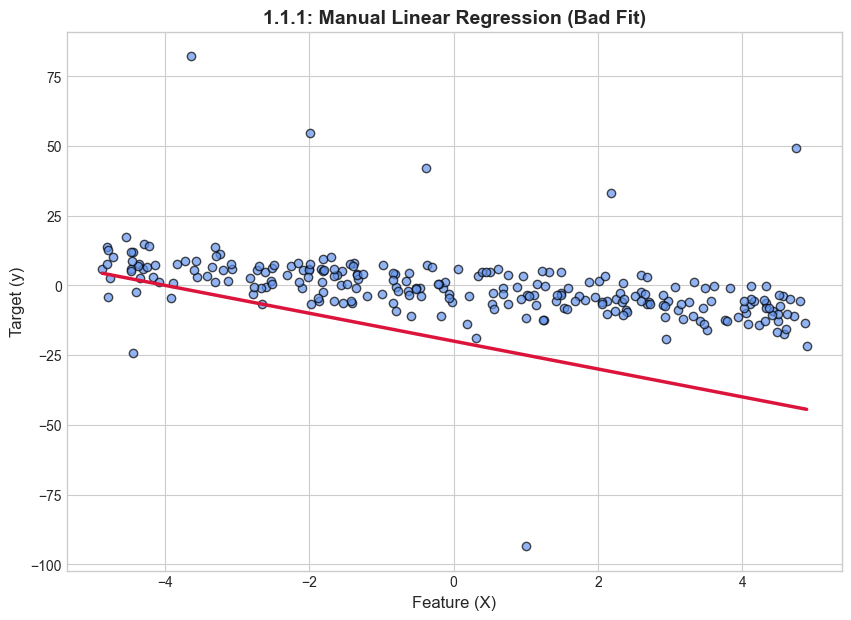


--- Експеримент 1.1.2 ---
----- Model Evaluation -----
MAE     17.0019
MSE    451.8883
RMSE    21.2577
R2      -2.0131
-----------------------------


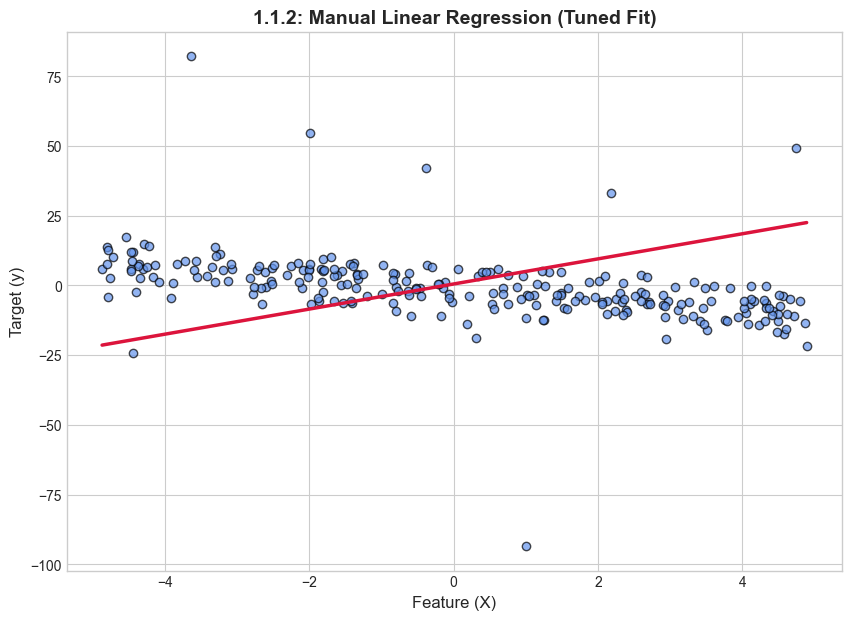

In [29]:
# Генерація лінійних даних
X_lin, y_lin = generate_regression_data(
    n_samples=250, 
    n_features=1, 
    mode='linear', 
    noise=5.0, 
    n_outliers=7, 
    random_seed=STUDENT_NO, 
    return_coef=False)

# Експеримент 1.1.1: Початкові ваги (y = -5x - 20) - Дуже поганий фіт
lin_model_weights_bad = [-5, -20]
print("--- Експеримент 1.1.1 (Початкове значення) ---")
evaluate_regression_model(y_lin, X_lin, model=lin_model_weights_bad, print_results=True)
plot_regression_model(X_lin, y_lin, 
                      weights=[lin_model_weights_bad[0], ], 
                      intercept=lin_model_weights_bad[1],
                      title='1.1.1: Manual Linear Regression (Bad Fit)')

# Експеримент 1.1.2: Налаштовані ваги (Пошук найкращої лінії)
lin_model_weights_tuned = [4.5, 0.5] 
print("\n--- Експеримент 1.1.2 ---")
evaluate_regression_model(y_lin, X_lin, model=lin_model_weights_tuned, print_results=True)
plot_regression_model(X_lin, y_lin, 
                      weights=[lin_model_weights_tuned[0], ], 
                      intercept=lin_model_weights_tuned[1],
                      title='1.1.2: Manual Linear Regression (Tuned Fit)')

--- 1.3.1 Huber (epsilon=1.0) - Sensitive ---
----- Model Evaluation -----
MAE      5.4747
MSE    122.7612
RMSE    11.0798
R2       0.1814
-----------------------------


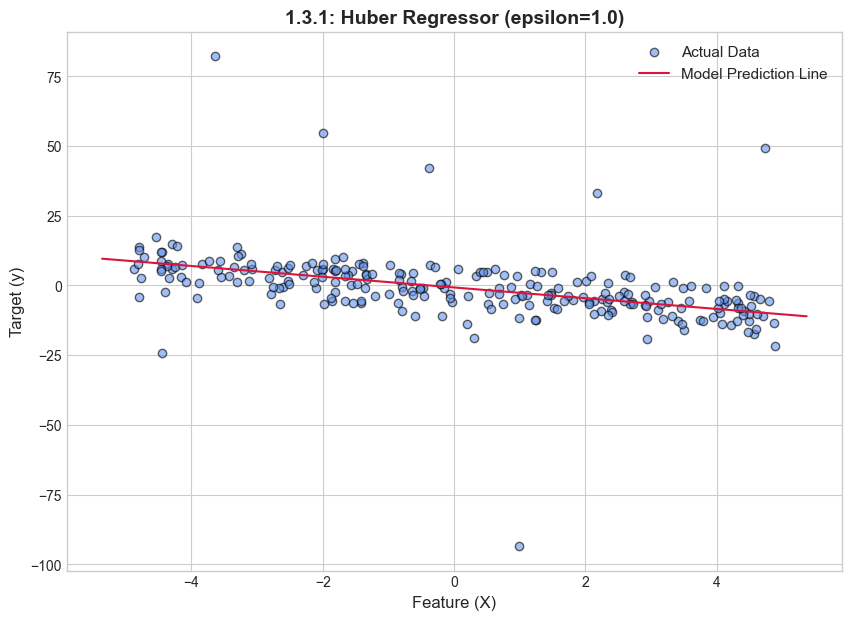


--- 1.3.2 Huber (epsilon=2.0) - Robust ---
----- Model Evaluation -----
MAE      5.4815
MSE    122.8185
RMSE    11.0824
R2       0.1811
-----------------------------


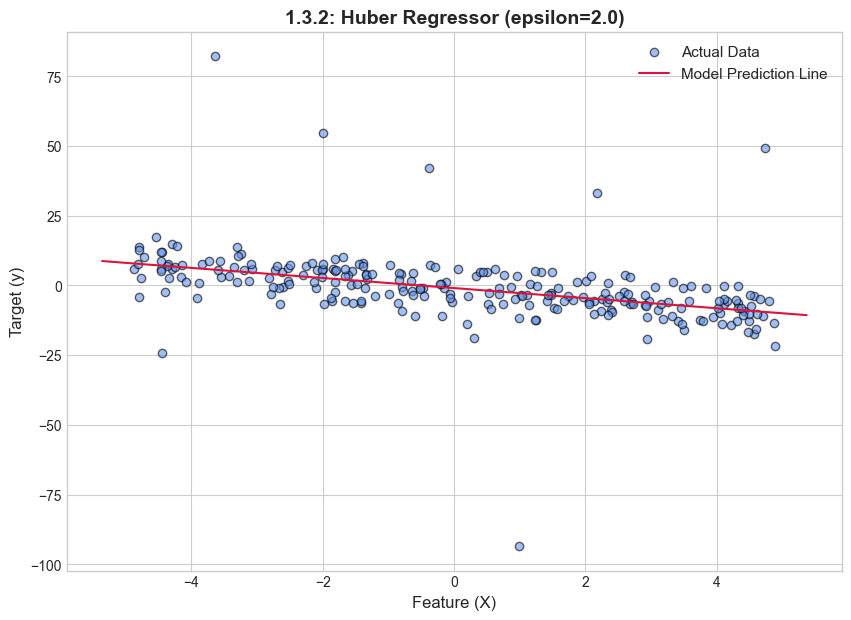

In [31]:
# Експеримент 1.3.1: HuberRegressor (налаштування epsilon)
# Мале epsilon: робить модель чутливішою до викидів (ближче до звичайної LR)
hub_model_sensitive = HuberRegressor(epsilon = 1.0, alpha = 0.0001) # ВИДАЛЕНО: random_state
hub_model_sensitive.fit(X_lin, y_lin)
print("--- 1.3.1 Huber (epsilon=1.0) - Sensitive ---")
evaluate_regression_model(y_lin, X_lin, model=hub_model_sensitive, print_results=True)
plot_sklearn_regression(hub_model_sensitive, X_lin.reshape(-1, 1), y_lin, 
                        title="1.3.1: Huber Regressor (epsilon=1.0)")

# Експеримент 1.3.2: HuberRegressor (налаштування epsilon)
# Велике epsilon: робить модель більш стійкою до викидів
hub_model_robust = HuberRegressor(epsilon = 2.0, alpha = 0.0001) # ВИДАЛЕНО: random_state
hub_model_robust.fit(X_lin, y_lin)
print("\n--- 1.3.2 Huber (epsilon=2.0) - Robust ---")
evaluate_regression_model(y_lin, X_lin, model=hub_model_robust, print_results=True)
plot_sklearn_regression(hub_model_robust, X_lin.reshape(-1, 1), y_lin, 
                        title="1.3.2: Huber Regressor (epsilon=2.0)")

--- 1.3.3 Poisson (alpha=0.1) ---
----- Model Evaluation -----
MAE      5.4887
MSE    122.5497
RMSE    11.0702
R2       0.1829
-----------------------------


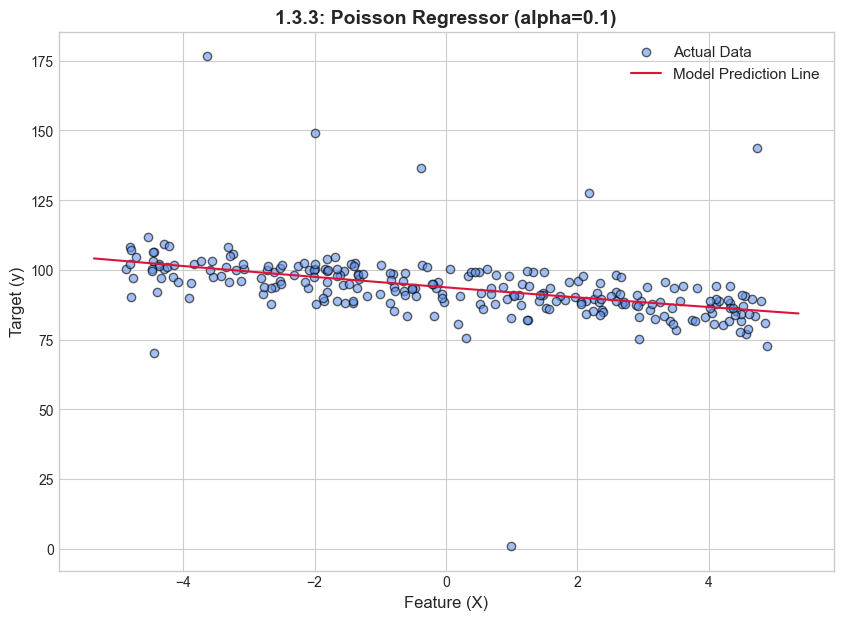

In [33]:
# Зсуваємо y_lin, щоб y >= 0
y_lin_shifted = y_lin - np.min(y_lin) + 1 # Додаємо 1, щоб уникнути log(0)

# Експеримент 1.3.3: PoissonRegressor
# Низьке alpha
pois_model_low_alpha = PoissonRegressor(alpha=0.1, solver="lbfgs", max_iter=100)
pois_model_low_alpha.fit(X_lin, y_lin_shifted)
print("--- 1.3.3 Poisson (alpha=0.1) ---")
evaluate_regression_model(y_lin_shifted, X_lin, model=pois_model_low_alpha, print_results=True)
plot_sklearn_regression(pois_model_low_alpha, X_lin.reshape(-1, 1), y_lin_shifted, 
                        title="1.3.3: Poisson Regressor (alpha=0.1)")

--- 1.4.1 KNN (k=2) - High Variance ---
----- Model Evaluation -----
MAE     4.1537
MSE    44.9497
RMSE    6.7045
R2      0.9855
-----------------------------


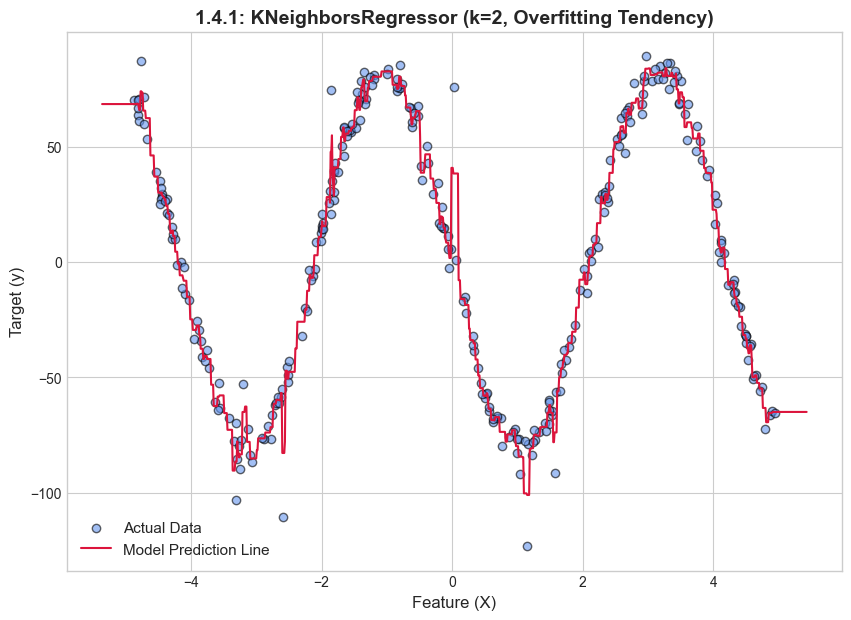


--- 1.4.2 KNN (k=20) - High Bias ---
----- Model Evaluation -----
MAE    0.0000
MSE    0.0000
RMSE   0.0000
R2     1.0000
-----------------------------


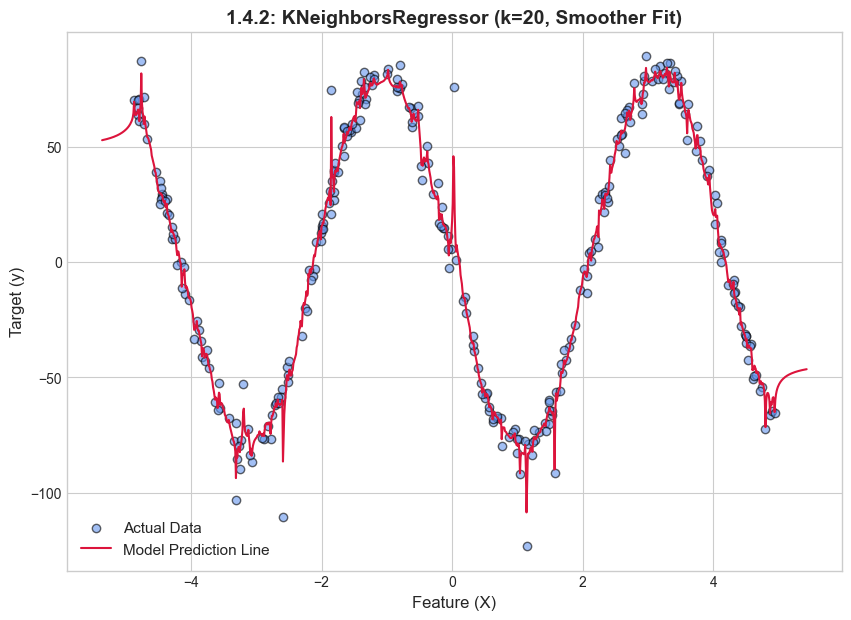

In [34]:
# Експеримент 1.4.1: Мале k (ризик перенавчання)
knn_model_low_k = KNeighborsRegressor(n_neighbors=2, weights='uniform')
knn_model_low_k.fit(X_nonlin, y_nonlin)
print("--- 1.4.1 KNN (k=2) - High Variance ---")
evaluate_regression_model(y_nonlin, X_nonlin, model=knn_model_low_k, print_results=True)
plot_sklearn_regression(knn_model_low_k, X_nonlin, y_nonlin, title="1.4.1: KNeighborsRegressor (k=2, Overfitting Tendency)")

# Експеримент 1.4.2: Більше k (згладжена крива)
knn_model_high_k = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn_model_high_k.fit(X_nonlin, y_nonlin)
print("\n--- 1.4.2 KNN (k=20) - High Bias ---")
evaluate_regression_model(y_nonlin, X_nonlin, model=knn_model_high_k, print_results=True)
plot_sklearn_regression(knn_model_high_k, X_nonlin, y_nonlin, title="1.4.2: KNeighborsRegressor (k=20, Smoother Fit)")

--- 1.4.3 DTR (max_depth=None) - Overfitting ---
----- Model Evaluation -----
MAE    0.0000
MSE    0.0000
RMSE   0.0000
R2     1.0000
-----------------------------


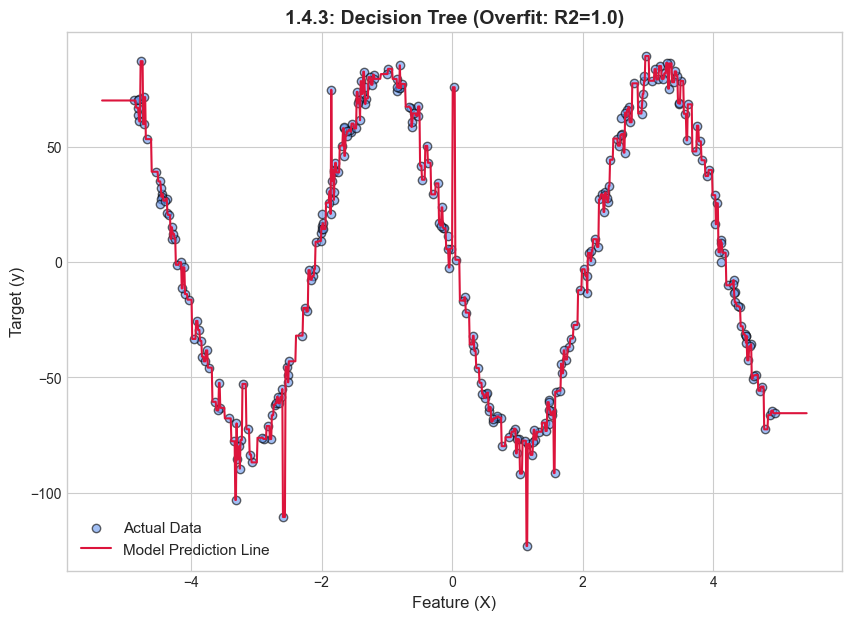


--- 1.4.4 DTR (max_depth=5) - Regularized ---
----- Model Evaluation -----
MAE      9.9968
MSE    195.3810
RMSE    13.9779
R2       0.9370
-----------------------------


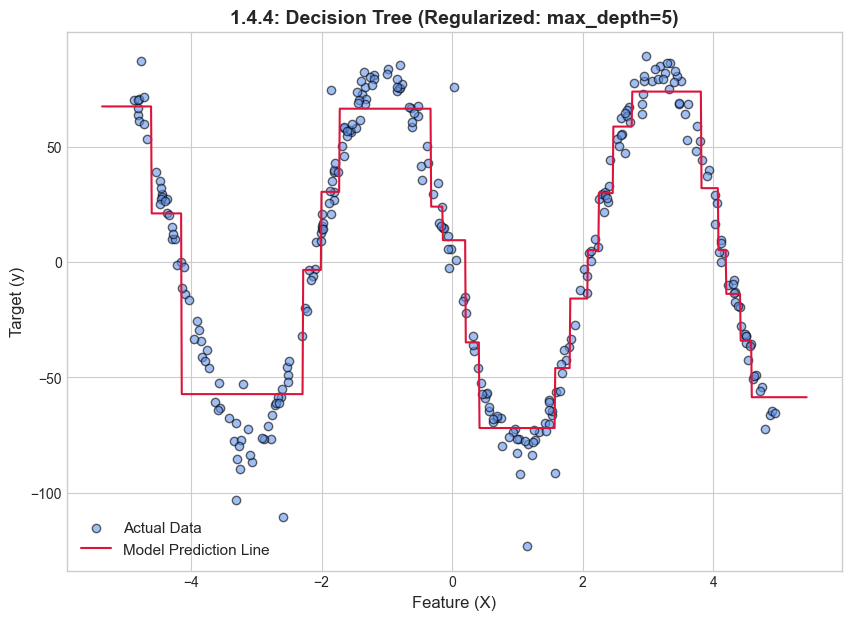

In [35]:
# Експеримент 1.4.3: Перенавчання (Overfitting)
# max_depth=None призводить до R2=1.0 на тренувальних даних
dt_model_overfit = DecisionTreeRegressor(max_depth=None, random_state=STUDENT_NO)
dt_model_overfit.fit(X_nonlin, y_nonlin)
print("--- 1.4.3 DTR (max_depth=None) - Overfitting ---")
evaluate_regression_model(y_nonlin, X_nonlin, model=dt_model_overfit, print_results=True)

plot_sklearn_regression(dt_model_overfit, X_nonlin, y_nonlin, 
                        title="1.4.3: Decision Tree (Overfit: R2=1.0)")

# Експеримент 1.4.4: Регуляризація (налаштування max_depth)
# Обмеження глибини покращує узагальнення
dt_model_regularized = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=STUDENT_NO)
dt_model_regularized.fit(X_nonlin, y_nonlin)
print("\n--- 1.4.4 DTR (max_depth=5) - Regularized ---")
evaluate_regression_model(y_nonlin, X_nonlin, model=dt_model_regularized, print_results=True)
plot_sklearn_regression(dt_model_regularized, X_nonlin, y_nonlin, title="1.4.4: Decision Tree (Regularized: max_depth=5)")

--- 1.4.5 SVR (C=100, gamma=1.0) - High C/Gamma ---
----- Model Evaluation -----
MAE      6.6424
MSE    107.0690
RMSE    10.3474
R2       0.9655
-----------------------------


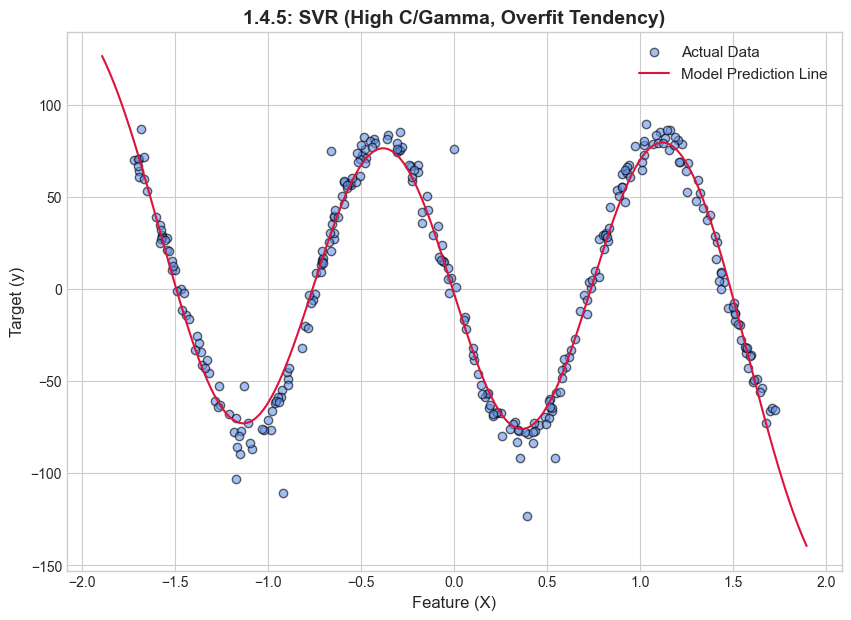


--- 1.4.6 SVR (C=1.0, gamma=0.1) - Smoother Fit ---
----- Model Evaluation -----
MAE      48.7874
MSE    3138.3349
RMSE     56.0208
R2       -0.0126
-----------------------------


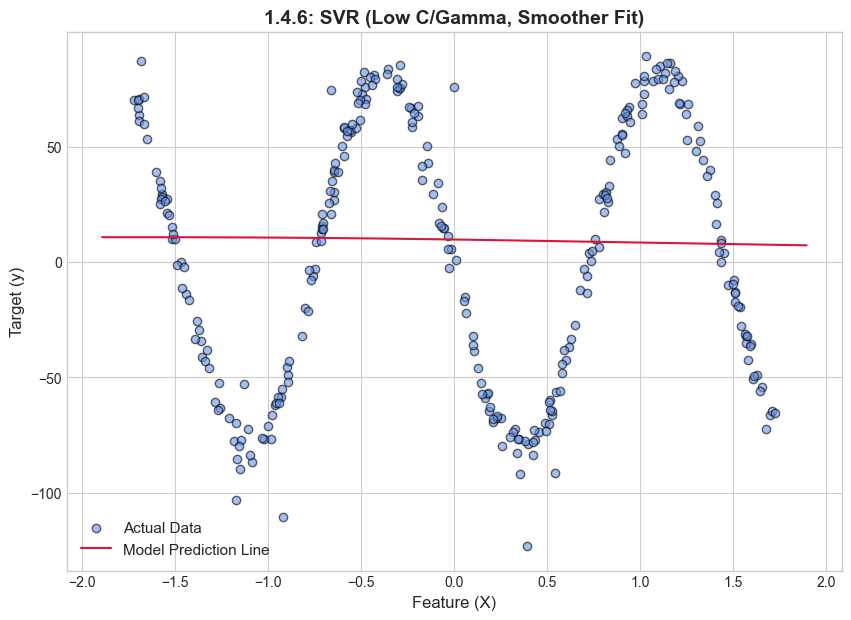

In [36]:
# SVR вимагає масштабування даних
scaler_nonlin = StandardScaler()
X_nonlin_scaled = scaler_nonlin.fit_transform(X_nonlin)

# Експеримент 1.4.5: SVR (Високі C та gamma - ризик перенавчання)
# C=100 (високий штраф), gamma=1.0 (сильний вплив зразків)
svr_model_high = SVR(kernel='rbf', C=100.0, gamma=1.0)
svr_model_high.fit(X_nonlin_scaled, y_nonlin)
print("--- 1.4.5 SVR (C=100, gamma=1.0) - High C/Gamma ---")
evaluate_regression_model(y_nonlin, X_nonlin_scaled, model=svr_model_high, print_results=True)
plot_sklearn_regression(svr_model_high, X_nonlin_scaled, y_nonlin, 
                        title="1.4.5: SVR (High C/Gamma, Overfit Tendency)")

# Експеримент 1.4.6: SVR (Низькі C та gamma - більш узагальнена модель)
# C=1.0 (менший штраф), gamma=0.1 (менший вплив зразків)
svr_model_low = SVR(kernel='rbf', C=1.0, gamma=0.1)
svr_model_low.fit(X_nonlin_scaled, y_nonlin)
print("\n--- 1.4.6 SVR (C=1.0, gamma=0.1) - Smoother Fit ---")
evaluate_regression_model(y_nonlin, X_nonlin_scaled, model=svr_model_low, print_results=True)
plot_sklearn_regression(svr_model_low, X_nonlin_scaled, y_nonlin, 
                        title="1.4.6: SVR (Low C/Gamma, Smoother Fit)")